In [1]:
import torchvision.models as models
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import nn
from cv2 import dnn_superres
import segmentation_models_pytorch as smp
from utils.dataset import BasicDataset
import cv2



from PIL import Image
paths = glob('img&mask/img/*')
paths_tmp = glob('img&mask_generated/img/*')

paths = []
for path in paths_tmp:
    img = Image.open(path)
    if np.array(img).shape[-1]==3:
        paths.append(path)
        
paths += glob('img&mask/img/*')

In [41]:
class AddCoords(nn.Module):
    def __init__(self, radius_channel=False,cuda=False):
        super(AddCoords, self).__init__()
        self.radius_channel = radius_channel
        self.cuda = cuda

    def forward(self, in_tensor):
        batch_size_tensor = in_tensor.shape[0]

        xx_ones = torch.ones([1, in_tensor.shape[2]], dtype=torch.int32)
        xx_ones = xx_ones.unsqueeze(-1)

        xx_range = torch.arange(in_tensor.shape[2], dtype=torch.int32).unsqueeze(0)
        xx_range = xx_range.unsqueeze(1)

        xx_channel = torch.matmul(xx_ones, xx_range)
        xx_channel = xx_channel.unsqueeze(-1)

        yy_ones = torch.ones([1, in_tensor.shape[3]], dtype=torch.int32)
        yy_ones = yy_ones.unsqueeze(1)

        yy_range = torch.arange(in_tensor.shape[3], dtype=torch.int32).unsqueeze(0)
        yy_range = yy_range.unsqueeze(-1)

        yy_channel = torch.matmul(yy_range, yy_ones)
        yy_channel = yy_channel.unsqueeze(-1)

        xx_channel = xx_channel.permute(0, 3, 1, 2)
        yy_channel = yy_channel.permute(0, 3, 1, 2)

        xx_channel = xx_channel.float() / (in_tensor.shape[2] - 1)
        yy_channel = yy_channel.float() / (in_tensor.shape[3] - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size_tensor, 1, 1, 1)
        yy_channel = yy_channel.repeat(batch_size_tensor, 1, 1, 1)
        
        if self.cuda:
            out = torch.cat([in_tensor.cuda(), xx_channel.cuda(), yy_channel.cuda()], dim=1)
        else:
            out = torch.cat([in_tensor.cpu(), xx_channel.cpu(), yy_channel.cpu()], dim=1)

        if self.radius_channel:
            radius_calc = torch.sqrt(torch.pow(xx_channel - 0.5, 2) + torch.pow(yy_channel - 0.5, 2))
            out = torch.cat([out, radius_calc], dim=1).cuda()

        return out

class Bbox:
    def __init__(self,model_path='bbox/bbox.pth',cuda=False):
        normalize = transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225]
        )
        self.ds_trans = transforms.Compose([transforms.ToTensor(),normalize,transforms.Resize((224,224))])
        self.model = nn.Sequential(
        AddCoords(cuda=cuda),
        nn.Conv2d(5,16,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16,16,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16,32,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32,64,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64,128,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        torch.nn.Linear(1152, 256),
        torch.nn.ELU(), torch.nn.Linear(256,4)
                )

        self.model.load_state_dict(torch.load(model_path))
        self.model = self.model.cpu()
        if cuda:
            self.model = self.model.cuda()
        self.cuda = cuda
            
    def _r_normer(self,r,alpha=0.3):
        a = r[1] - r[0]
        a*=alpha
        b = r[3] - r[2]
        b*=alpha
        r = [r[0]-a,r[1]+a,r[2]-b,r[3]+b]
        out = []
        for i in r:
            if i<0:
                out.append(0)
            elif i>1:
                out.append(1)
            else:
                out.append(float(i.cpu()))
        return out
            
    def predict(self,img):
        #PIL
        batch = self.ds_trans(img).unsqueeze(0)
        if self.cuda:
            batch = batch.cuda()
        else:
            batch = batch.cpu()
        
        batch = batch.float()
        r = self.model(batch)[0]
        r = self._r_normer(r)
        
        return r
        
        
class Segment_net:
    def __init__(self,model_path='checkpoints_UnetPlusPlus/CP_epoch_285.pth',cuda=False):
        self.model = smp.UnetPlusPlus(
            encoder_name="resnet34",        
            encoder_weights="imagenet",    
            in_channels=3,                 
            classes=1,  
            decoder_attention_type='scse',
        )
        self.model.load_state_dict(torch.load(model_path))
        if cuda:
            self.model = self.model.cuda()
        else:
            self.model = self.model.cpu()

        self.cuda = cuda
        
    def image_mask(self,full_img):
        #PIL
        img = torch.from_numpy(BasicDataset.preprocess(full_img, 1))
        img = img.unsqueeze(0)
        if self.cuda:
            img = img.cuda()
        
        self.model.eval()
        with torch.no_grad():
            output = self.model(img.float())


            probs = torch.sigmoid(output)

            probs = probs.squeeze(0)

            tf = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.Resize(full_img.size[1]),
                    transforms.ToTensor()
                ]
            )

            probs = tf(probs.cpu())
            full_mask = probs.squeeze().cpu().numpy()
            full_mask = full_mask*255
            full_mask = full_mask.astype(np.uint8)
            return full_mask

    def predict(self,img):
        size = img.size
        img = img.resize((512,480))
        mask = self.image_mask(img)
        blur = cv2.blur(mask,(5,5))
        b_channel, g_channel, r_channel = cv2.split(np.array(img))
        img_BGRA = cv2.merge((b_channel, g_channel, r_channel, blur))

        return Image.fromarray(img_BGRA).resize(size)
    
class ResizeModel:
    def __init__(self,model_path='FSRCNN_x2.pb'):
        self.sr = dnn_superres.DnnSuperResImpl_create()
        self.sr.readModel(model_path)
        self.sr.setModel("fsrcnn", 2)
    
    def predict(self,img,size):
        #cv2
        img = np.array(img)
        size = (size[1],size[0])
        while min(img.shape[:-1]) < min(size):
            img = self.sr.upsample(img)

        img = cv2.resize(img,dsize=size,interpolation=cv2.INTER_CUBIC)
        return Image.fromarray(img)

In [42]:
bb_model = Bbox(cuda=False)
seq_model = Segment_net(cuda=False)
up_sample = ResizeModel()

In [33]:
def image_crop_to_aspect(img,bb_model=bb_model,a=3,b=4):
    r = bb_model.predict(img)
    a_img,b_img = img.size
    b_min = int(r[0]*b_img)
    b_max = int(r[1]*b_img)
    a_min = int(r[2]*a_img)
    a_max = int(r[3]*a_img)
    
    b_len = b_max - b_min
    a_len = a_max - a_min
    
    if a_len/b_len < a/b:
        new_a = b_len*a/b
        diff = new_a - a_len 
        diff/=2
        diff = int(diff)
        a_min-=diff
        if a_min<0:
            a_min = 0
        a_max+=diff
    else:
        new_b = a_len*b/a
        diff = new_b - b_len
        diff/=2
        diff = int(diff)
        b_min-=diff
        if b_min<0:
            b_min = 0
        b_max+=diff
        
    return Image.fromarray(np.array(img)[b_min:b_max,a_min:a_max])

In [34]:
paths = glob('validation/*.jpg')

In [35]:
img = Image.open(paths[98])

In [36]:
class ImageProcessor:
    def __init__(self,seg_model_path='checkpoints_UnetPlusPlus/CP_epoch_285.pth',
                bbox_model_path='bbox/bbox.pth',resize_model_path='FSRCNN_x2.pb',cuda=False):
        self.bb_model = Bbox(model_path=bbox_model_path, cuda=cuda)
        self.seq_model = Segment_net(model_path=seg_model_path, cuda=cuda)
        self.up_sample = ResizeModel(model_path=resize_model_path)
        
    def _crop_image_to_aspect_ratio(self,img,a=3,b=4):
        r = self.bb_model.predict(img)
        a_img,b_img = img.size
        b_min = int(r[0]*b_img)
        b_max = int(r[1]*b_img)
        a_min = int(r[2]*a_img)
        a_max = int(r[3]*a_img)

        b_len = b_max - b_min
        a_len = a_max - a_min

        if a_len/b_len < a/b:
            new_a = b_len*a/b
            diff = new_a - a_len 
            diff/=2
            diff = int(diff)
            a_min-=diff
            if a_min<0:
                a_min = 0
            a_max+=diff
        else:
            new_b = a_len*b/a
            diff = new_b - b_len
            diff/=2
            diff = int(diff)
            b_min-=diff
            if b_min<0:
                b_min = 0
            b_max+=diff

        return Image.fromarray(np.array(img)[b_min:b_max,a_min:a_max])
    
    def image_process(self,img,size=(900,1200),use_segmentation=False):
        img = self._crop_image_to_aspect_ratio(img,size[0],size[1])
        img = self.up_sample.predict(img,size)
        if use_segmentation:
            img = self.seq_model.predict(img)
            
        return img

In [37]:
processor = ImageProcessor()

In [46]:
img = Image.open(paths[1])

In [47]:
res = bb_model.predict(img)

In [48]:
a,b = img.size

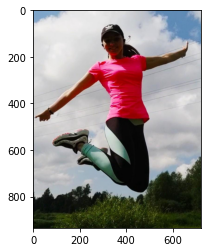

In [49]:
plt.imshow(np.array(img)[int(b*res[0]):int(b*res[1]),int(a*res[2]):int(a*res[3])])

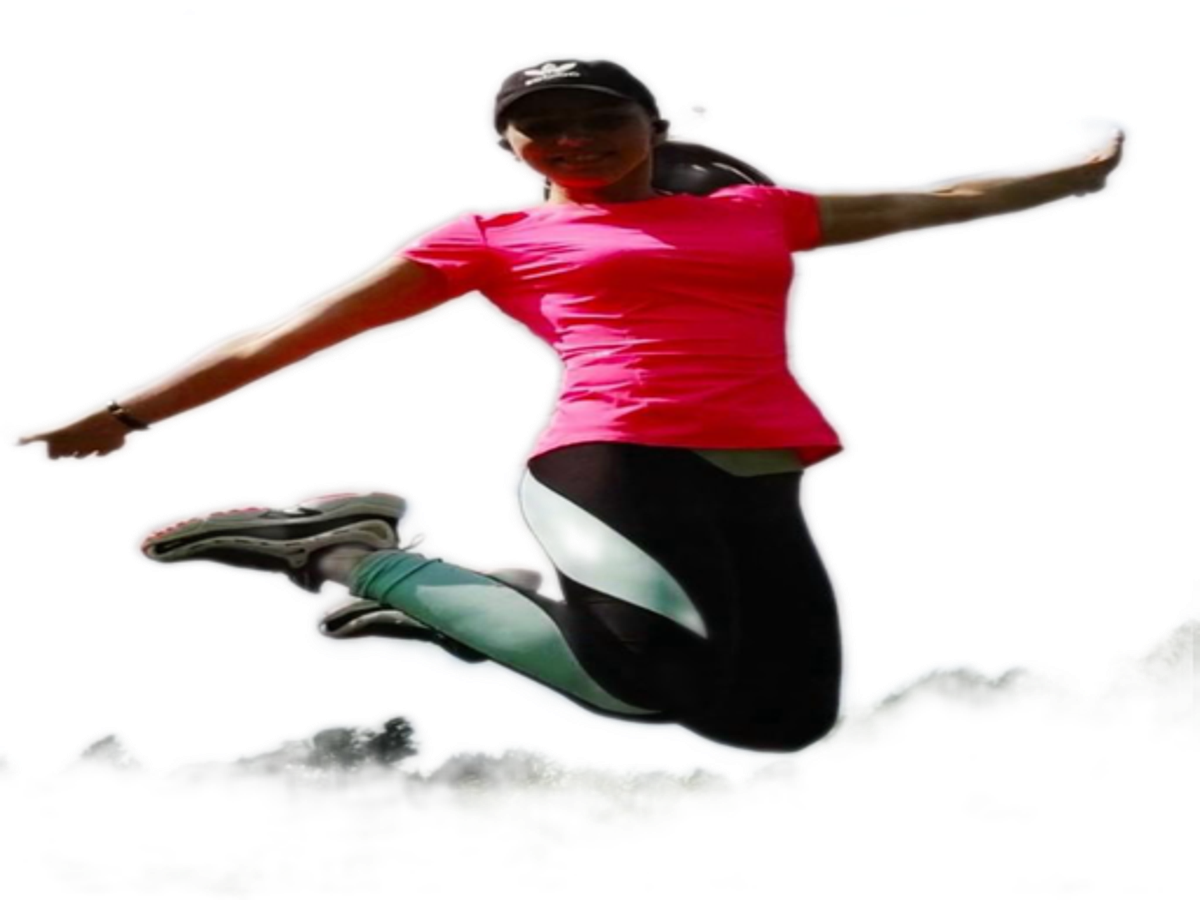

In [51]:
processor.image_process(img,use_segmentation=True)

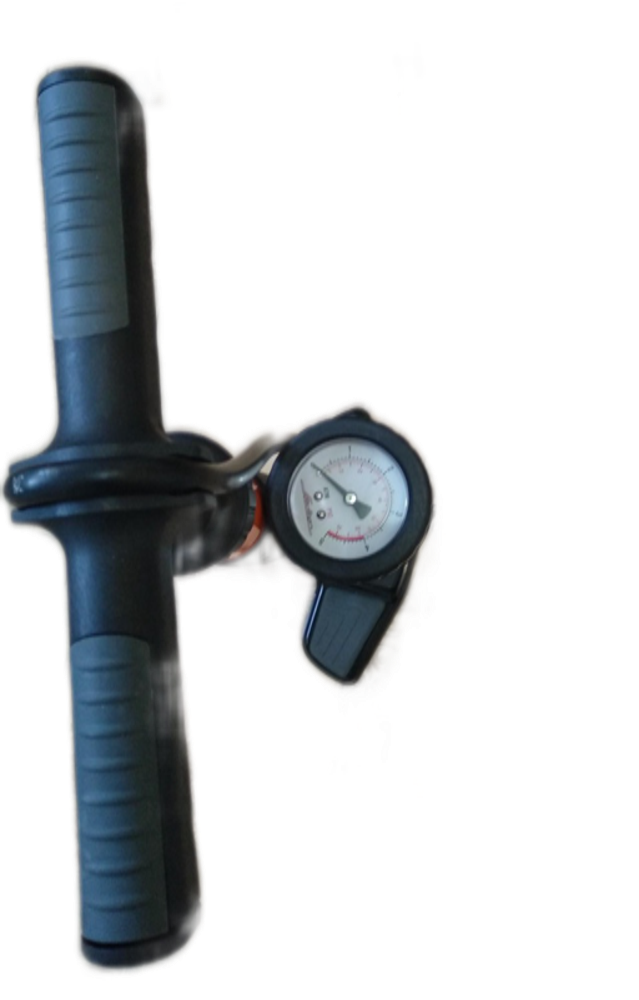

In [13]:
seq_model.predict(img)

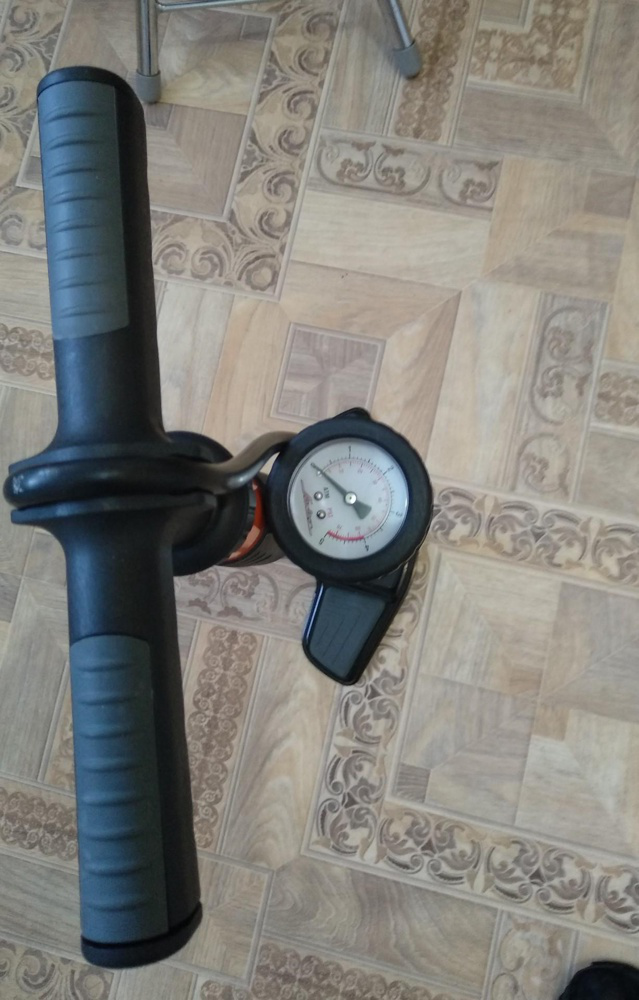

In [12]:
img